In [45]:
# 필요한 라이브러리 import
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings

In [52]:
# 데이터 불러오기
train = pd.read_csv("./open/train.csv")
test = pd.read_csv("./open/test.csv")

# 데이터 구조 확인하기

In [17]:
train.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness,target
0,TRAIN_00000,27.8816,1013.6,46.8,2.4,232.4,0.00,False,0.0,1.180
1,TRAIN_00001,5.7540,1026.6,76.6,3.6,172.0,0.00,False,8.8,8.581
2,TRAIN_00002,20.8220,1016.2,64.8,2.2,206.0,0.06,False,23.0,3.978
3,TRAIN_00003,20.0758,1017.4,72.6,0.8,215.4,0.00,False,0.0,8.301
4,TRAIN_00004,7.5260,1023.2,82.8,1.2,158.0,0.00,False,15.0,1.692


In [18]:
test.head()

,id,temperature,pressure,humidity,wind_speed,wind_direction,precipitation,snowing,cloudiness
0,TEST_00000,20.702000,1021.0,76.4,2.0,104.8,0.00,False,23.0
1,TEST_00001,18.673669,1014.4,59.6,2.4,179.2,0.12,False,32.4
2,TEST_00002,29.908000,1020.6,49.6,2.6,78.0,0.60,False,23.0
3,TEST_00003,24.504000,1014.6,61.0,1.8,118.0,0.00,False,15.0
4,TEST_00004,12.590000,1011.4,70.8,1.8,110.0,0.12,False,34.0


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19275 non-null  object 
 1   temperature     19275 non-null  float64
 2   pressure        19275 non-null  float64
 3   humidity        19275 non-null  float64
 4   wind_speed      19275 non-null  float64
 5   wind_direction  19275 non-null  float64
 6   precipitation   19275 non-null  float64
 7   snowing         19275 non-null  bool   
 8   cloudiness      19275 non-null  float64
 9   target          19275 non-null  float64
dtypes: bool(1), float64(8), object(1)
memory usage: 1.3+ MB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19275 entries, 0 to 19274
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19275 non-null  object 
 1   temperature     19275 non-null  float64
 2   pressure        19275 non-null  float64
 3   humidity        19275 non-null  float64
 4   wind_speed      19275 non-null  float64
 5   wind_direction  19275 non-null  float64
 6   precipitation   19275 non-null  float64
 7   snowing         19275 non-null  bool   
 8   cloudiness      19275 non-null  float64
dtypes: bool(1), float64(7), object(1)
memory usage: 1.2+ MB


In [21]:
le = LabelEncoder()
train['snowing'] = pd.Series(le.fit_transform(train['snowing']))
test['snowing'] = pd.Series(le.fit_transform(test['snowing']))

In [22]:
warnings.filterwarnings(action = 'ignore') # 경고를 무시해줌

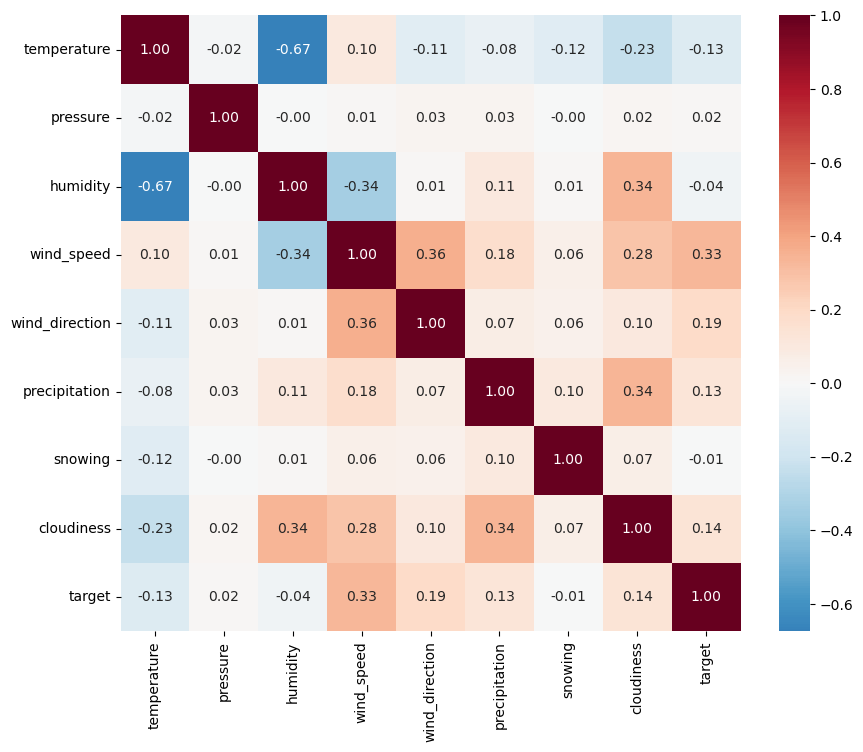

In [23]:
# 상관성 확인하기
plt.figure(figsize = (10,8))
sns.heatmap(train.drop(columns=['id'], axis=1).corr(),
           annot = True, fmt = '.2f', cmap = 'RdBu_r', center = 0)
plt.show()

 -> target변수와 가장 상관성이 높은 변수 : wind_speed

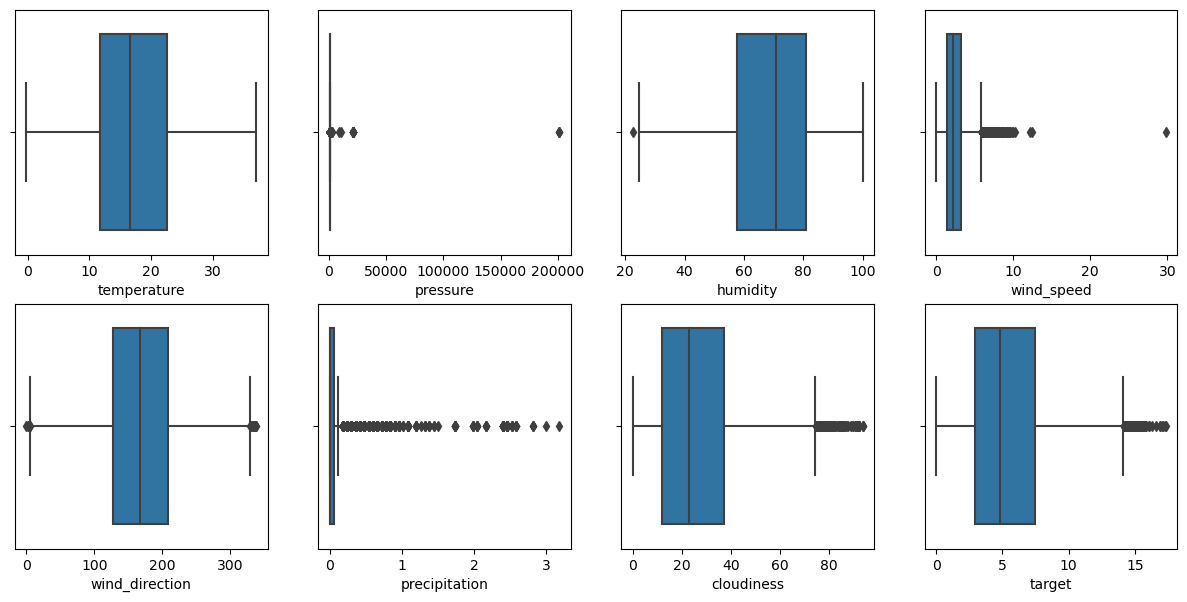

In [24]:
# 이상치 확인하기
fig, axes = plt.subplots(2,4, figsize=(15,7))
a=0;b=0

sns.boxplot(train['temperature'], ax = axes[0][0])
sns.boxplot(train['pressure'], ax = axes[0][1])
sns.boxplot(train['humidity'], ax = axes[0][2])
sns.boxplot(train['wind_speed'], ax = axes[0][3])
sns.boxplot(train['wind_direction'], ax = axes[1][0])
sns.boxplot(train['precipitation'], ax = axes[1][1])
sns.boxplot(train['cloudiness'], ax = axes[1][2])
sns.boxplot(train['target'], ax = axes[1][3])

plt.show()

In [56]:
# target과 상관성이 높은 변수의 이상치 제거 (이상치가 많기 때문에 다 제거하면 오히려 안좋음)

Q1 = train.describe().loc['25%']
Q3 = train.describe().loc['75%']
IQR = Q3 - Q1
u = Q3 + 1.5 * IQR
l = Q1 - 1.5 * IQR
outline = pd.DataFrame({'lower':l, 'upper':u})
outline

index = train[(train['wind_speed']<=outline.loc['wind_speed','lower']) | (train['wind_speed'] >= outline.loc['wind_speed','upper'])].index
train = train.drop(index, axis = 0)

# pressure 변수의 동떨어져 있는 데이터 제거
index = train[(train['pressure']>150000)].index
train = train.drop(index, axis = 0)

In [58]:
train.info() # 데이터 개수가 19275개 에서 18826개로

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18826 entries, 0 to 19274
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18826 non-null  object 
 1   temperature     18826 non-null  float64
 2   pressure        18826 non-null  float64
 3   humidity        18826 non-null  float64
 4   wind_speed      18826 non-null  float64
 5   wind_direction  18826 non-null  float64
 6   precipitation   18826 non-null  float64
 7   snowing         18826 non-null  bool   
 8   cloudiness      18826 non-null  float64
 9   target          18826 non-null  float64
dtypes: bool(1), float64(8), object(1)
memory usage: 1.5+ MB


# 모델링

In [59]:
input_var = ['temperature','pressure','humidity','wind_speed','wind_direction','precipitation','snowing','cloudiness']

In [60]:
# xgboost 데이터 모델링
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1)
xgb.fit(train[input_var], train['target'])
train['pred'] = xgb.predict(train[input_var])
abs(train['target']-train['pred']).mean()

1.6288826879323606

In [61]:
# lightGBM 데이터 모델링
lgbm = LGBMRegressor(n_estimators=300, learning_rate=0.1)
lgbm.fit(train[input_var],train['target'])
train['pred'] = lgbm.predict(train[input_var])
abs(train['pred']-train['target']).mean()

1.6906790463477335

In [62]:
# RandomForest 데이터 모델링
rf = RandomForestRegressor(n_estimators=300)
rf.fit(train[input_var], train['target'])
train['pred']=rf.predict(train[input_var])
abs(train['target']-train['pred']).mean()

0.7192368650833095

In [63]:
# 선형회귀 모형 데이터 모델링
LR = LinearRegression()
LR.fit(train[input_var], train['target'])
train['pred']=LR.predict(train[input_var])
abs(train['target']-train['pred']).mean()

2.318190812677409

-> RandomForest모델이 가장 MAE가 작을 것처럼 보임

# RandomForest 모델링

<function matplotlib.pyplot.show(close=None, block=None)>

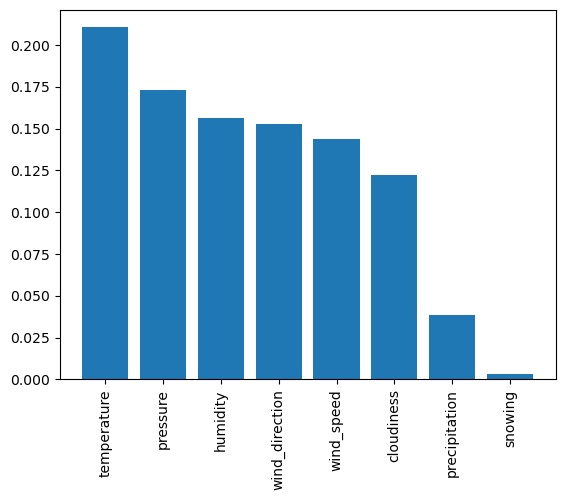

In [64]:
# 변수중요도가 큰 순으로 input variables
imt = pd.DataFrame({'var':input_var, 'import':rf.feature_importances_}).sort_values(by='import',ascending=False)

plt.bar(imt['var'], imt['import'])
plt.xticks(rotation=90)
plt.show

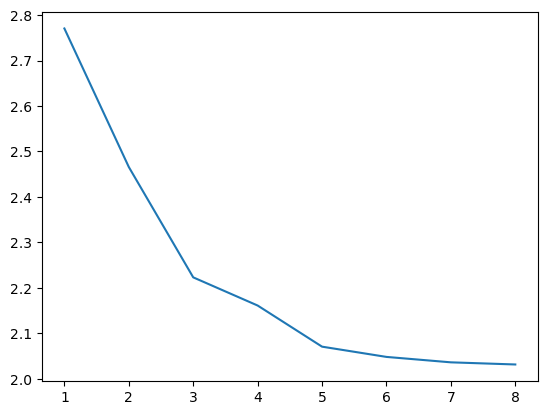

In [65]:
# input 변수 개수는 몇 개가 좋을 지?
score_list = [] # MAE 점수 리스트
varnum = [] # input 변수 개수 리스트

for i in range(1,len(imt)+1):
    select_var = imt['var'].iloc[:i].to_list()
    scores = cross_val_score(rf, train[select_var], train['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())
    varnum.append(i)

plt.plot(varnum, score_list) 

In [66]:
score_list

[2.770494576820621,
 2.465624973733583,
 2.222746923747106,
 2.160760765848633,
 2.070225520200608,
 2.0476666904145646,
 2.0357357730414463,
 2.031021942380081]

-> input변수는 8개 일 때 가장 좋음

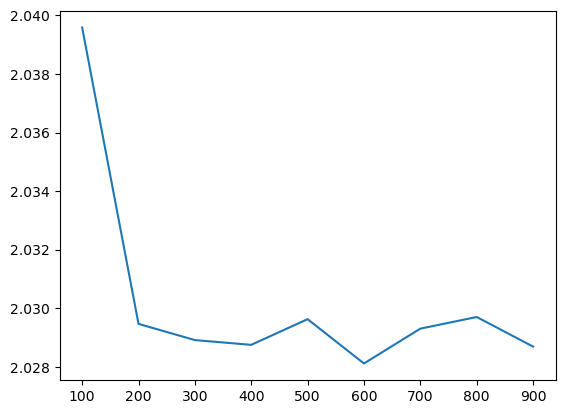

In [67]:
# n_estimators 파라미터는 몇이 좋을지?
estimators_list = [100,200,300,400,500,600,700,800,900]
score_list = []

for i in estimators_list:
    rf = RandomForestRegressor(n_estimators=i)
    scores = cross_val_score(rf, train[input_var], train['target'], scoring = 'neg_mean_absolute_error', cv = 3)
    score_list.append(-scores.mean())

plt.plot(estimators_list, score_list)

In [69]:
rf = RandomForestRegressor(n_estimators=600)
rf.fit(train[input_var], train['target'])
test['target'] = rf.predict(test[input_var])
test[['id','target']].to_csv("submission.csv", index = False)